In [1]:
import math
import random
import time

import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

import logging

In [2]:
ROBOT_L = 0.145
ROBOT_W = 0.16
WHEEL_R = 0.065/2

In [3]:
def linearTrapezoid(d,vMax,a):
    # Return keypoints in velocity profile
    accelTime = vMax/a
    
    accelD = accelTime*vMax
    dLeft = d - accelD
    
    if(dLeft >= 0):
        
        coastTime = float(dLeft) / vMax
        return np.array([[0.0,0.0], [accelTime, vMax], [accelTime+coastTime, vMax], [accelTime+coastTime+accelTime,0.0]])
    else:
        
        accelTime = math.sqrt(d / a)
        vCoast = accelTime * a
        return np.array([[0.0,0.0], [accelTime, vCoast], [accelTime+accelTime, 0.0]])

In [4]:
def linearInterp(profile, t):
    # Check sorted by time
    if(np.all(np.diff(profile[:,0]) < 0)):
        # Decreasing time
        raise ValueError("Time not sorted")
    
    n = len(profile)
    # Get t section
    t = np.expand_dims(t,0)
    
    profileT = np.expand_dims(profile[:,0], -1)
    profileV = np.expand_dims(profile[:,1], -1)
    
    pre = t >= profileT
    post = t <= profileT
    
    v = np.zeros((t.shape[1]), dtype=np.float)
    
    # Check inside of range
    insideMask = np.logical_and(np.any(post, axis=0), np.any(pre, axis=0))
    
    preInd = n-np.argmax(pre[::-1], axis=0)-1
    postInd = np.argmax(post, axis=0)

    # Same
    sameMask = preInd == postInd
    
    mask = np.logical_and(sameMask, insideMask)
    v[mask] = profile[preInd[mask],1]
    
    # Interpolate Mask
    # Preind always less than postind in sorted list
    interpMask = preInd < postInd
    mask = np.logical_and(interpMask, insideMask)
    tPre = profile[preInd[mask],0]
    tPost = profile[postInd[mask],0]
    
    vPre = profile[preInd[mask],1]
    vPost = profile[postInd[mask],1]
    
    dt = np.divide(t[0][mask] - tPre, tPost - tPre)
    v[mask] = np.multiply(dt, vPost - vPre) + vPre
    
    return v

In [5]:
def profileArea(profile):
    area = 0.0
    for n in range(len(profile) - 1):
        area += 0.5*(profile[n][1] + profile[n+1][1])*(profile[n+1][0] - profile[n][0])
    return area

In [6]:
def simulate(x0, commands, dt, f, timeEnd = 10, plotPeriod = 0.5, xlim=[-5,5], ylim=[-5,5]):
    
    fig = plt.figure()
    plt.show(block=False)
    fig.canvas.draw()
    
    curTime = 0
    x = x0
    commandIndex = 0
    commandTime = 0
    curCommand = np.array([[0.0], [0.0]])
    
    lastPlot = 0
    
    while curTime < timeEnd:
        
        if(commandIndex < len(commands)):
            commandDelay, curCommand = commands[commandIndex]
            if(curTime - commandTime >= commandDelay):
                commandIndex += 1
                commandTime = curTime
        
        x = f(x, curCommand, dt)
        
        
        if(curTime - lastPlot >= plotPeriod):
            
            fig.clear()
            
            currentPos = np.array([[x[0,0], x[3,0]]])
            plt.scatter(currentPos[:,0], currentPos[:,1])

            plt.quiver([currentPos[0,0]], [currentPos[0,1]], [math.cos(x[6,0])], [math.sin(x[6,0])])
            
            velocity = np.array([[x[1,0], x[4,0]]])
            if(np.linalg.norm(velocity) > 1e-3):
                plt.quiver([currentPos[0,0]], [currentPos[0,1]], velocity[:,0], velocity[:,1], scale=1)
            
            plt.xlim(xlim)
            plt.ylim(ylim)
            plt.grid()
            
            #plt.gca().clear()
            fig.canvas.draw()
            plt.pause(0.01)
            #plt.show()
            lastPlot = curTime
        else:
            time.sleep(0.01)
        #print(f"[{curTime}]\n{x}")
        #plt.clear()
        #plt.show()
        
        #if(curTime > 0.60):
        #    break
        
        curTime += dt
        
    print(x)
    

In [7]:
def f(xn, un1, dt):
    k = 0.1
    dt2 = dt*dt
    w = math.tan(un1[1,0]) * (xn[1,0]*math.cos(xn[6,0]) + xn[4,0]*math.sin(xn[6,0])) / ROBOT_L
    xn1 = np.array([
        [xn[0,0] + xn[1,0] * dt + 0.5 * xn[2,0] * dt2],
        [xn[1,0] + xn[2,0] * dt],
        [k*(un1[0,0]*math.cos(xn[6,0]) - xn[1,0]) / dt],
        [xn[3,0] + xn[4,0] * dt + 0.5 * xn[5,0] * dt2],
        [xn[4,0] + xn[5,0] * dt],
        [k*(un1[0,0]*math.sin(xn[6,0]) - xn[4,0]) / dt],
        [xn[6,0] + xn[7,0] * dt],
        [w]
    ])
    return xn1
    

In [8]:
dt = 0.01

In [9]:
trajectDt = 0.4

In [10]:
MAX_ACC = 1.5 * WHEEL_R * 2 * math.pi
INTER_CMD_DELAY = 1

In [11]:
cmdSet = [
    ('line', 0.6, 0.2),
    ('arc', 2*math.pi/2, 0.4, 0.2),
]

In [12]:
commands = [
]

In [13]:
for cmd in cmdSet:

        t = 0
        r = 0

        if(cmd[0] == 'line'):
            d = cmd[1]
            v = cmd[2]
        elif(cmd[0] == 'arc'):
            r = cmd[2]
            v = cmd[3]

            dAngle = cmd[1]
            d = r*dAngle

        steeringAngle = 0
        if(r != 0):
            steeringAngle = math.atan(ROBOT_L/r)

        vProfile = linearTrapezoid(abs(d), abs(v), MAX_ACC)

        discreteProfile = linearInterp(vProfile, np.arange(0, vProfile[-1,0] + 0.5, trajectDt))
        if(d < 0):
            discreteProfile *= -1
        print(f"Profile:\n{discreteProfile}")
        dProfile = np.sum(discreteProfile) * trajectDt
        print(f"Area Check:{dProfile}")
        if(cmd[0] == 'arc'):
            print(f"Yaw Change Check:{(180/math.pi)*dProfile / r}")
        if(d != dProfile):
            discreteProfile *= d/dProfile
        if(cmd[0] == 'arc'):
            print(f"Yaw Change Check:{(180/math.pi)*np.sum(discreteProfile) * trajectDt / r}")
        print(f"Area Check (Corrected):{np.sum(discreteProfile) * trajectDt}")
                
        for c in discreteProfile:

            commands.append((trajectDt, np.array([[c], [steeringAngle]])))

        commands.append((INTER_CMD_DELAY, np.array([[0],[0]])))

Profile:
[0.         0.12252211 0.2        0.2        0.2        0.2
 0.2        0.2        0.13873894 0.01621683 0.        ]
Area Check:0.5909911546039991
Area Check (Corrected):0.6000000000000001
Profile:
[0.         0.12252211 0.2        0.2        0.2        0.2
 0.2        0.2        0.2        0.2        0.2        0.2
 0.2        0.2        0.2        0.2        0.16421904 0.04169693
 0.        ]
Area Check:1.2513752338979152
Yaw Change Check:179.24629872386691
Yaw Change Check:180.0
Area Check (Corrected):1.2566370614359172


In [14]:
commands

[(0.4,
  array([[0.],
         [0.]])),
 (0.4,
  array([[0.12438979],
         [0.        ]])),
 (0.4,
  array([[0.20304872],
         [0.        ]])),
 (0.4,
  array([[0.20304872],
         [0.        ]])),
 (0.4,
  array([[0.20304872],
         [0.        ]])),
 (0.4,
  array([[0.20304872],
         [0.        ]])),
 (0.4,
  array([[0.20304872],
         [0.        ]])),
 (0.4,
  array([[0.20304872],
         [0.        ]])),
 (0.4,
  array([[0.14085383],
         [0.        ]])),
 (0.4,
  array([[0.01646403],
         [0.        ]])),
 (0.4,
  array([[0.],
         [0.]])),
 (1,
  array([[0],
         [0]])),
 (0.4,
  array([[0.        ],
         [0.34776699]])),
 (0.4,
  array([[0.1230373 ],
         [0.34776699]])),
 (0.4,
  array([[0.20084097],
         [0.34776699]])),
 (0.4,
  array([[0.20084097],
         [0.34776699]])),
 (0.4,
  array([[0.20084097],
         [0.34776699]])),
 (0.4,
  array([[0.20084097],
         [0.34776699]])),
 (0.4,
  array([[0.20084097],
         [0.34

In [15]:
x0 = np.array([
    [0.0],
    [0.0],
    [0.0],
    [0.0],
    [0.0],
    [0.0],
    [0.0],
    [0.0],
])

<IPython.core.display.Javascript object>


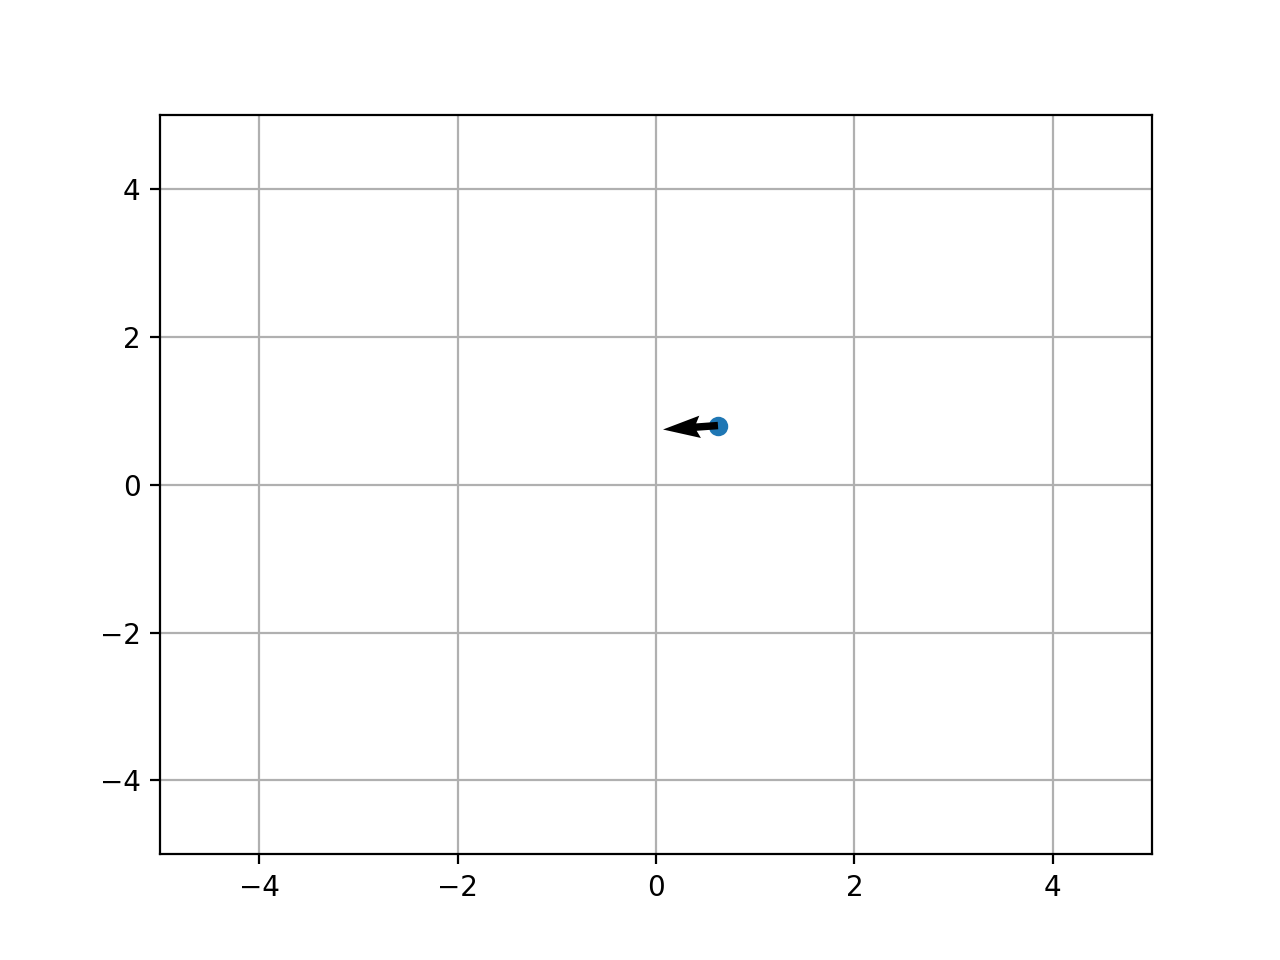

[[ 6.24716300e-01]
 [-4.79891842e-91]
 [ 5.40846098e-90]
 [ 8.01685965e-01]
 [-2.27287408e-92]
 [ 2.56156693e-91]
 [ 3.21364633e+00]
 [ 0.00000000e+00]]


In [16]:
simulate(x0, commands, dt, f, timeEnd = 30)

In [9]:
x0.shape

(8, 1)

In [10]:
commands[0][1].shape

(2, 1)

In [11]:
x0[:,0]

array([0., 1., 0., 0., 0., 0., 0., 0.])